In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [154]:
data = {
'Рыночная цена': [987.9, 972.81, 966.99, 889.49, 917.95, 920.56, 924.49, 922.59, 844.97, 865.0, 814.85, 826.60, 901.49, 838.29, 739.49, 852.0, 894.0, 792.91, 910.90, 752.0, 659.99, 704.5, 881.54, 728.5, 670.0 ],
'Срок до погашения, дн': [68, 206, 297, 570, 689, 997, 1018, 1137, 1382, 1487, 1606, 1977, 2075, 2299, 2635, 2824, 3251, 3377, 3734, 3790, 4224, 4602, 5260, 5561, 6352],
'Номинал': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
'Сумма купона': [32.41, 36.90, 35.40, 22.44, 35.65, 38.64, 39.64, 40.64, 29.92, 35.15, 28.42, 34.91, 44.88, 38.15, 29.42, 42.38, 47.37, 38.39, 47.47, 36.15, 30.42, 34.90, 48.87, 38.39, 35.40],
'Срок до выплаты купона': [[68], [26, 206], [117, 297], [26, 206, 386, 570],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
}

In [155]:
df = pd.DataFrame(data)

In [79]:
df

,Рыночная цена,"Срок до погашения, дн",Номинал,Сумма купона,Срок до выплаты купона
0,985.6,68,1000,32.41,[68]
1,969.6,201,1000,36.90,"[26, 201]"
2,963.2,293,1000,35.40,"[117, 293]"
3,888.1,545,1000,22.44,"[26, 206, 386, 545]"


In [160]:
df['Бескупонная доходность'] = [14.27, 13.01, 11.99, 13.12, 12.69, 11.61, 11.64, 11.58, 11.59, 11.60, 11.79, 11.74, 11.72, 11.75, 11.67, 11.70, 11.79, 11.88, 11.78, 11.78, 11.79, 11.86, 11.96, 11.92, 11.91]

In [161]:
df['Лет до погашения'] = (df['Срок до погашения, дн']/365).round(2)

In [58]:
g_curve = np.array([])

for ind, row in df.iterrows():
    maturity = row['Срок до погашения, дн']
    coupon_dates = row['Срок до выплаты купона']
    coupon_amount = row['Сумма купона']
    bond_yield = row['Бескупонная доходность']

In [59]:
g_curve

array([], dtype=float64)

In [60]:
for coupon_date in coupon_dates:
    # Расчет времени до купона в долях года
    time_to_coupon = coupon_date / 365

    # Расчет дисконтированной значения купона
    discounted_coupon = coupon_amount / (1 + bond_yield / 100)**time_to_coupon

    # Добавление дисконтированной купонной выплаты к g-кривой
    g_curve = np.append(g_curve, discounted_coupon)

# Расчет дисконтированной значения номинала
discounted_nominal = df['Номинал'][ind] / (1 + bond_yield / 100)**(maturity / 365)

# Добавление дисконтированного номинала к g-кривой
g_curve = np.append(g_curve, discounted_nominal)

In [90]:
g_curve

array([ 22.25816216,  21.03905652,  19.88672272,  18.92144058,
       843.20145171])

In [62]:
time = np.arange(len(g_curve))

In [87]:
time = df['Лет до погашения'].to_list()

In [88]:
time

[0.19, 0.55, 0.8, 1.49]

In [115]:
def g_curve_model(t, params):

    beta0, beta1, beta2, tau1, g1, g2, g3, g4, g5, g6, g7, g8, g9 = params

    k = 1.6
    a1 = 0
    a2 = 0.6
    a3 = a2 + a2 * k**1
    a4 = a3 + a2 * k**2
    a5 = a4 + a2 * k**3
    a6 = a5 + a2 * k**4
    a7 = a6 + a2 * k**5
    a8 = a7 + a2 * k**6
    b1 = a2
    b2 = b1 * k
    b3 = b2 * k
    b4 = b3 * k
    b5 = b4 * k
    b6 = b5 * k
    b7 = b6 * k
    b8 = b7 * k

    return beta0 + (beta1 + beta2)*(tau1/t)*(1 - np.exp(-t/tau1)) - beta2*np.exp(-t/tau1) + g1*np.exp(-((t-a1)**2)/b1**2) + g2*np.exp(-((t-a2)**2)/b2**2)+ g3*np.exp(-((t-a3)**2)/b3**2) + g4*np.exp(-((t-a4)**2)/b4**2) + g5*np.exp(-((t-a5)**2)/b5**2) + g6*np.exp(-((t-a6)**2)/b6**2) + g7*np.exp(-((t-a7)**2)/b7**2) + g8*np.exp(-((t-a8)**2)/b8**2)




In [165]:
t = np.linspace(0.01, 17, 100)

In [166]:
params = [1126.95, 366.00, -374.43, 0.32,	0.48,	-0.95,	8.35,	-1.83,	-2.28,	-1.22,	-0.77,	0.00, 0.00]

In [167]:
result = (g_curve_model(t, params)/100).round(2)

In [ ]:
result

In [174]:
data1 = {'t': np.linspace(0.01, 17, 100), 'Y' :[(g_curve_model(t, params)/100).round(2) for t in np.linspace(0.01, 17, 100)] }

In [176]:
df1 = pd.DataFrame(data1)

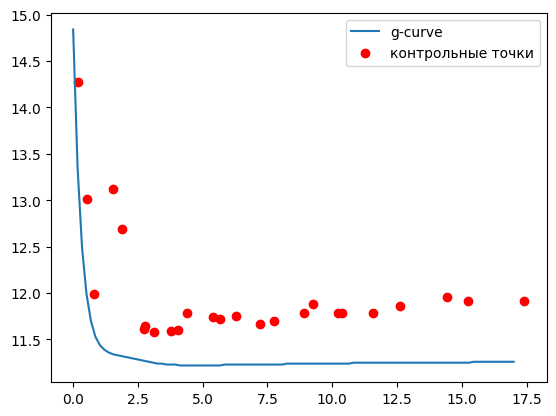

In [179]:
plt.plot(df1['t'], df1['Y'], label = 'g-curve')
# plt.plot(df2['x'], df2['y2'], label = 'y2 = 10 -x')
plt.scatter(df['Лет до погашения'], df['Бескупонная доходность'], color = 'r', label = 'контрольные точки' )
plt.legend()
plt.show()